
# Image Recognition Using Convolutional Neural Network


## Introduction

This tutorial will introduce you to some basic kownledge about deep learning, we will focus on how to implement convolutional neural network in Keras and use this technique to do some simple image recognition. 

Keras is a high-level neural networks library, written in Python and capable of running on top of either TensorFlow or Theano. It was developed with a focus on enabling fast experimentation. 


## Tutorial content
In this tutorial, we will show you how to build basic deep learning networks using Keras in python, and give an example about simple image processing.

We'll be using data from THE MNIST DATABASE (http://yann.lecun.com/exdb/mnist/). This database is like the "Hello World" part for image recognition. It is a database of handwritten digits, with a training set of 60,000 examples, and a test set of 10,000 examples. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting.

We will cover the following topics in this tutorial:

1. Basic knowledge about deep learning and CNN
2. Build a CNN in Keras


## Basic knowledge about deep learning and CNN

###  Deep Learning

In order to do some deep learning, we first need to have a training model. The model is a network structure which consists of many functions. The picture below shows what a **fully connected feedforward network** is like. The network is consists of many layers, and each layer contains many neurons. Each neuron of the previous layer is connected to the neurons of the next layer.
<img src="layer.png",width=600,height=600>

The picture below shows how one neuron can be calculated by the neurons of the previous layer and the weight between two connecting neurons:
<img src="neuron.png",width=600,height=600>

By choosing the right network structure, we can get an output with very low loss.

### About CNN (Convolutional Neural Network)

In deep learning, a convolutional neural network (CNN, or ConvNet) is a type of feed-forward artificial neural network in which the connectivity pattern between its neurons is inspired by the organization of the animal visual cortex. It has wide applications in image and video recognition, recommender systems and natural language processing.

**There are three important steps in CNN: convolution, max pooling and flatten.**
Let me show you what are these steps. 

For example, in order to classify the image below, we need to know whether it's a picture of bird. 
<img src="bird.jpg",width=400,height=400>
We need to extract features from birds. One of the features is the beak. So while doing deep learning, we will need neurons (sometimes one is enough) to detect whether there is a beak. 
<img src="beak.png",width=100,height=100>
The point of CNN is that some patterns are much smaller than the whole image. And a neuron does not have to see the whole image to discover the pattern. A CNN is able to focus on small regions with less parameters. That's why we will have convolution in CNN.

Also, subsampling the pixels will not change the object. So we can subsample the pixels to make the image smaller and hence less parameters for the network to process the image. That's why we will have max pooling in CNN.
<img src="whole.png",width=800,height=800>



The picture above shows the three steps of CNN. 

In **convolution** part, we use several filters to calculate each parts of the image, and convert the results into a new matrix. The new matrix is a feature map corresponding to the filter. We do the same process for each filter. Notice that there are overlaps in the input while calculating the feature map, this will help to obtain a better representation of the original image.

In **max pooling** part, we devide the feature maps into small pieces and pool out the maximmum of each piece. Then we will get several new but smaller images. For example, in the picture above, we divide the feature map into four 2×2 pieces and we take the maximum of each pieced and get a smaller matrix. This step will efficiently reduce the number of parameters.
We can repeat the convolution and max pooling parts for many times.

After the first two steps, we **flatten** the small images we get and put into the fully connected feedforward network. Then we walk through all the fully connected layers to get the output.

## Let's build a CNN in Keras

### Installing the libraries:

https://keras.io/#installation
Follow the instruction on the website above. We will use Tensorflow as its backend.


In [7]:
import tensorflow as tf
tf.python.control_flow_ops = tf #To avoid some incompatible between keras and tensorflow

In [8]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD
from keras import backend as K
# load mnist data directly from keras datasets
from keras.datasets import mnist 
import numpy as np
# fix random seed for reproducibility
seed = 111
np.random.seed(seed)

### Load Data

Now, let's take a closer look at the dataset we are going to use.
It is a database of handwrite digits. Each image is 28 pixels by 28 pixels. So we can interpret this as a 2D array of numbers. And each image has a corresponding label to show the digit.
The mnist data set can easily be loaded in Keras. Let's load the data and separate it into two tuples: (X is the image, Y is the corresponding label)


In [10]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Then we can plot images directly using matplotlib:

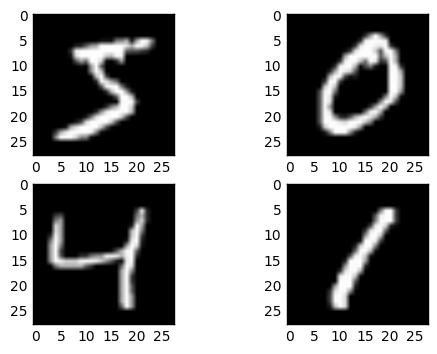

In [11]:
import matplotlib
import matplotlib.pyplot as plt

plt.subplot(221)
plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train[3], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

Then we need to do some data processing. Keras have two shape models for images: one is "tf", which means the images have shape (samples, width, height, channels), the other is "th", which means the images have shape (samples, channels, width, height).
So we are going to use image_dim_ordering() to checkout what shape the model is and extract that shape.

In [12]:
# input image dimensions
img_rows, img_cols = 28, 28

if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

('X_train shape:', (60000, 28, 28, 1))
('X_test shape:', (10000, 28, 28, 1))
(60000, 'train samples')
(10000, 'test samples')


In order to understand the input values better, let's normalize the data. The maximum observation is 255.
Since the data is loaded as integers, we must cast it to floating point values for division.

In [14]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
classes = 10
X_test_r = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

# convert the labels to binary class matrices
Y_train = np_utils.to_categorical(y_train, classes)
Y_test = np_utils.to_categorical(y_test, classes)
print('Y_test shape:', Y_test.shape)
print('X_test shape:', X_test.shape)

('Y_test shape:', (10000, 10))
('X_test shape:', (10000, 28, 28, 1))


### Define Model

**Models** in Keras are defined as a sequence of layers.
Let’s start off by defining a simple CNN structure as a baseline and evaluate how well it performs on the problem.
We need to set up some parameters first:

We will use a structure with two convolutional layers followed by max pooling and a flattening out of the network to fully connected layers to make predictions.

Our convolutional neural network structure can be summarized as follows:

1. The first convolutional input layer, 30 feature maps in size of 5×5, a rectifier activation function "ReLU".
2. One max Pool layer in size of 2×2.
3. The second convolutional layer, 15 feature maps with in size of 3×3, a rectifier activation function "ReLU".
4. One max Pool layer in size of 2×2.
5. Dropout 20% data for training.
6. One flatten layer.
7. The first fully connected layer with 128 units and a rectifier activation function "ReLU".
8. The second fully connected layer with 50 units and a rectifier activation function "ReLU".
9. Fully connected output layer with 10 units and a softmax activation function.


In [15]:
#parameters
# two different convolutional filters to use
filters1 = 30
filters2 = 15
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution filter sizes
filter_size1 = (5, 5)
filter_size2 = (3, 3)

In [16]:
# create model
model = Sequential()

#first convolutional input layer
model.add(Convolution2D(filters1, 
                        filter_size1[0], 
                        filter_size1[1],
                        border_mode = 'valid',
                        input_shape = input_shape))
model.add(Activation('relu'))

# max Pool layer
model.add(MaxPooling2D(pool_size = pool_size))

#second convolutional layer
model.add(Convolution2D(filters2, 
                        filter_size2[0], 
                        filter_size2[1]))
model.add(Activation('relu'))

# max Pool layer
model.add(MaxPooling2D(pool_size = pool_size))

#dropout set to 20%
model.add(Dropout(0.2))

#flatten layer
model.add(Flatten())

#first fully connected layer
model.add(Dense(128))
model.add(Activation('relu'))

#second fully connected layer
model.add(Dense(50))
model.add(Activation('relu'))

#third fully connected layer
model.add(Dense(classes))
model.add(Activation('softmax'))

### Rectifier and Dropout

While going through the model, you may find there are some parameters unfamilier to you.

**Rectifier**

In the context of artificial neural networks, the rectifier is an activation function defined as
f(x)=max(0,x) where x is the input to a neuron.

ReLU is short for "rectified linear unit. The fuction is shown in the figure below. Using ReLU can help us filter out the neurals with unexpected value and improve the compute efficiency.
<img src="relu.png",width=100,height=100>

**Dropout**

Doupout some portion of the neurons while training is a good way to prevent from overfitting.
The intuitive understanding is that imagine you are working on a project. When teaming up, if everyone expect the partner will do the work, nothing will be done finally, However, if you know your partner will dropout, you will do better. Notice that **when testing, no one dropout actually**, so we will obtain good results eventually.

And assuming the dropout rate is 50%, then for that layer, only 50% of the neurals will have contribution to the next layer. So we the training weight will be twice as much as the real testing weight. So the weigths should multiply (1-p)% will testing.


### Compile Model

Now that the model is defined, we can compile it.

In [17]:
# Compile model

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

While compiling the network. We use Adaptive Moment Estimation(adam) algorithm to get our model.

The website below introduces different gradient descent optimization algorithms:
http://sebastianruder.com/optimizing-gradient-descent/index.html#stochasticgradientdescent

### Fit Model

We have defined our model and compiled it ready for efficient computation.
Now it is time to execute the model on the test data.

Epochs is the number of iterations for gradient descent. And while training our network, we divide the data into equally-sized batches. We take each batch as training samples and get the mean. This will help us minimize our gradient matrix and save memory in the learning process.

In [18]:
# fit the model
batch_size = 200
epochs = 10

hist = model.fit(X_train, Y_train, 
              batch_size = batch_size, 
              nb_epoch = epochs, 
              verbose = 1, 
              validation_data=(X_test, Y_test))


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 53s - loss: 1.2710 - acc: 0.5719 - val_loss: 0.5411 - val_acc: 0.8338
Epoch 2/10
60000/60000 [==============================] - 50s - loss: 0.5425 - acc: 0.8272 - val_loss: 0.3470 - val_acc: 0.8966
Epoch 3/10
60000/60000 [==============================] - 51s - loss: 0.4073 - acc: 0.8711 - val_loss: 0.2596 - val_acc: 0.9215
Epoch 4/10
60000/60000 [==============================] - 50s - loss: 0.3196 - acc: 0.9002 - val_loss: 0.1933 - val_acc: 0.9436
Epoch 5/10
60000/60000 [==============================] - 50s - loss: 0.2449 - acc: 0.9237 - val_loss: 0.1422 - val_acc: 0.9568
Epoch 6/10
60000/60000 [==============================] - 60s - loss: 0.1971 - acc: 0.9389 - val_loss: 0.1185 - val_acc: 0.9643
Epoch 7/10
60000/60000 [==============================] - 54s - loss: 0.1700 - acc: 0.9472 - val_loss: 0.0994 - val_acc: 0.9678
Epoch 8/10
60000/60000 [==============================

The output of the fitting part should be like:
<img src="output.png",width=1000,height=1000>


Minimun error:0.071118, at iteration: 10
drawing the training process...


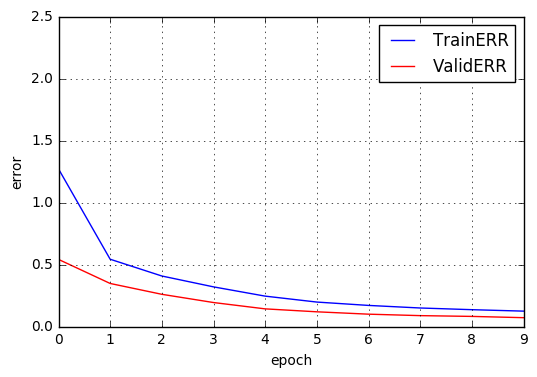

In [19]:
# draw the figure of errors in each epoch
TrainERR=hist.history['loss']
ValidERR=hist.history['val_loss']
print ('Minimun error:%f, at iteration: %i' % (np.min(np.asarray(ValidERR)),
                                               np.argmin(np.asarray(ValidERR))+1))
print 'drawing the training process...'

plt.figure(1)
plt.plot(TrainERR,'b',label='TrainERR')
plt.plot(ValidERR,'r',label='ValidERR')
plt.ylim([0.0,2.5])
plt.legend()
plt.xlabel('epoch')
plt.ylabel('error')
plt.grid(True)
plt.show()

The error-epoch figure will be like:
<img src="error.png",width=600,height=600>
This shows how training error and validation error decrease as the number of gradient descent iteration increases.

### Evaluate Model

We have trained our neural network on the entire dataset and we can evaluate the performance of the network on the same test data.

In [21]:
# evaluate the model
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

print("Baseline Error: %.2f%%" % (100-score[1]*100))

('Test score:', 0.071118034629337495)
('Test accuracy:', 0.97699999999999998)
Baseline Error: 2.30%


The output should be:
('Test score:', 0.071118034629337495)
('Test accuracy:', 0.97699999999999998)
Baseline Error: 2.30%

We can see that the error rate is relatively small, but there are still some ways to improve the performance of the network. Try to figure it out by yourself!

## Reference:
1. Keras official documentation 
2. Picture of models from various tech blogs
2. Stanford CS231n 2016 Jan Lectures 
3. Handwritten Digit Recognition using Convolutional Neural Networks in Python with Keras